Cosine distance is equal to the [inner product of unit vectors](https://stats.stackexchange.com/questions/146221/is-cosine-similarity-identical-to-l2-normalized-euclidean-distance).

"When [np.linalg.norm()](https://sparrow.dev/numpy-norm/) is called on an array-like input without any additional arguments, the default behavior is to compute the L2 norm on a flattened view of the array. This is the square root of the sum of squared elements and can be interpreted as the length of the vector in Euclidean space."


## To Do:

* Compute and plot ROC curves based on individual clusters: we don't want all the ones with a score of 0 to be considered one group if they really include many different clusters.

* 

In [1]:
import regex, os, sys
import numpy as np
import pandas as pd
import pickle
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.core.display import HTML
from sklearn.cluster import KMeans
from sklearn.linear_model import LogisticRegressionCV

from ThoughtGraph import ThoughtGraph, tg_utils
from aa_cluster import *
from text_patterns import patterns

N_CLUSTERS = 200
SEED = 0

DATA_FILE = "dolly_pos_clusters_5gram.parquet"
MODELS_FILE = "positive_and_negative_reweighting_models.pickle"

FP_TYPE = 'float32'

In [2]:
instruction_data = pd.read_parquet(DATA_FILE)[['instruction', 'category', 'instruction_vector']] # 'pos_tfidf_PCs'
instruction_data['instruction_vector'] = [v.astype(FP_TYPE) for v in instruction_data['instruction_vector']]
instruction_data['unit_vector'] = to_unit_vectors(instruction_data['instruction_vector'])

# instruction_data['unit_vector'][0].dtype  # 'float32'

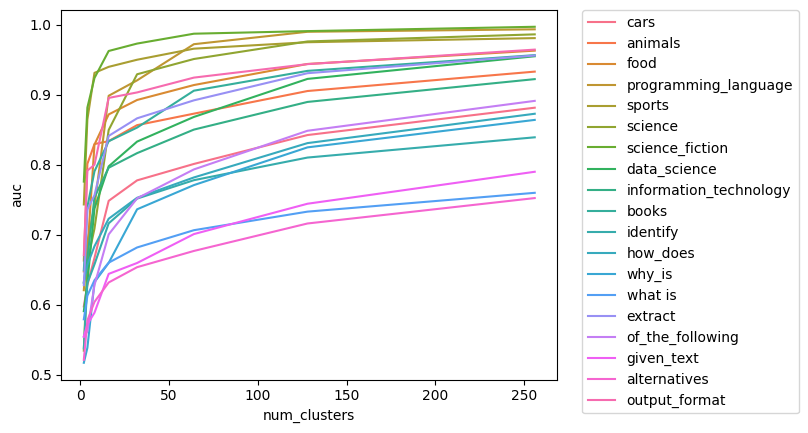

In [4]:
dendro = get_cluster_dendrogram(instruction_data['unit_vector'])

pattern_flags = find_pattern_flags_in_text(instruction_data['instruction'], patterns)

if os.path.exists(MODELS_FILE):
    my_models = pickle.load(open(MODELS_FILE, "rb"))
else:
    my_models = train_pattern_models(instruction_data['instruction_vector'], pattern_flags, verbose=True)
    pickle.dump(my_models, open(MODELS_FILE, "wb"))
    
pattern_scores = get_model_scores_for_vectors(instruction_data['instruction_vector'], my_models)

mean_xval_auc = get_model_mean_xval_auc(my_models)

cluster_assignment_df = get_cluster_assignments(dendro)

cluster_rocs_step1 = get_cluster_rocs(pattern_flags, cluster_assignment_df)  # TO DO: combine these two functions!!!
cluster_roc_df = extract_cluster_roc_df(cluster_rocs_step1)
plot_cluster_aucs(cluster_roc_df)


In [31]:
cluster_roc_df

,flag,num_clusters,auc,roc
0,cars,2,0.597382,"{'fpr': [0.0, 0.5440414507772021, 1.0], 'tpr':..."
1,cars,4,0.627966,"{'fpr': [0.0, 0.4646632124352332, 0.6776511226..."
2,cars,8,0.666723,"{'fpr': [0.0, 0.2858721934369603, 0.3462521588..."
3,cars,16,0.748313,"{'fpr': [0.0, 0.0037996545768566492, 0.0446286..."
4,cars,32,0.777572,"{'fpr': [0.0, 0.0037996545768566492, 0.0232124..."
...,...,...,...,...
147,output_format,16,0.895445,"{'fpr': [0.0, 0.01491013071895425, 0.056644880..."
148,output_format,32,0.903309,"{'fpr': [0.0, 0.01491013071895425, 0.039011437..."
149,output_format,64,0.924505,"{'fpr': [0.0, 0.0009531590413943355, 0.0149101..."
150,output_format,128,0.943776,"{'fpr': [0.0, 0.0009531590413943355, 0.0098039..."


8 ['0.597', '0.628', '0.667', '0.748', '0.778', '0.801', '0.842', '0.881']


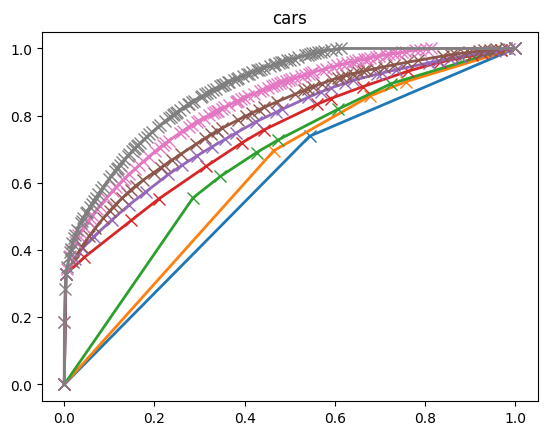

In [32]:
plot_aspect_roc_curves('cars', cluster_roc_df)

8 ['0.663', '0.801', '0.829', '0.834', '0.857', '0.873', '0.905', '0.933']


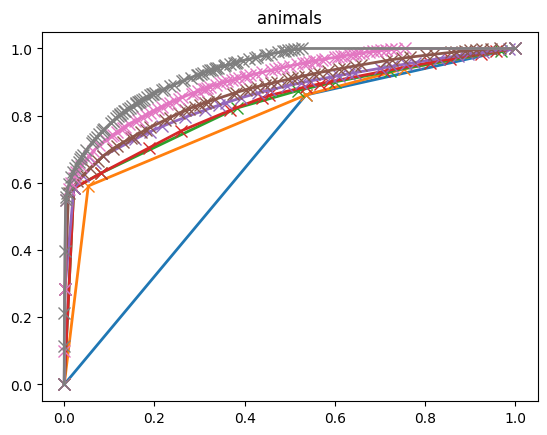

In [33]:
plot_aspect_roc_curves('animals', cluster_roc_df)

8 ['0.621', '0.690', '0.740', '0.899', '0.921', '0.972', '0.990', '0.994']


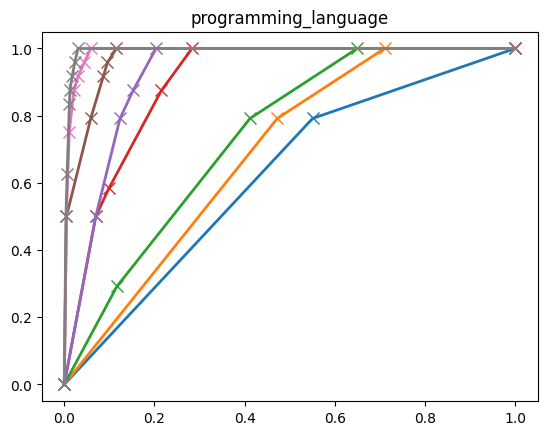

In [34]:
plot_aspect_roc_curves('programming_language', cluster_roc_df)

# Where is the red curve?

8 ['0.521', '0.577', '0.604', '0.632', '0.653', '0.677', '0.716', '0.752']


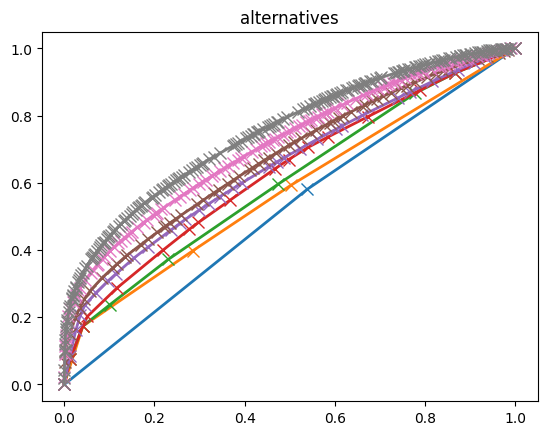

In [35]:
plot_aspect_roc_curves('alternatives', cluster_roc_df)

8 ['0.671', '0.792', '0.800', '0.895', '0.903', '0.925', '0.944', '0.965']


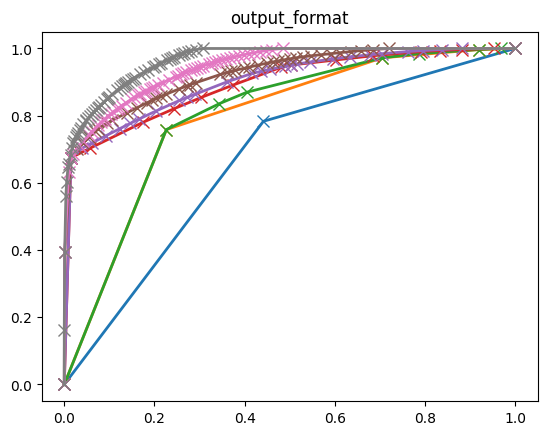

In [36]:
plot_aspect_roc_curves('output_format', cluster_roc_df)

# Re-weight embeddings

In [39]:
animal_modifier = my_models['animals'].coef_.astype(FP_TYPE)

projection = np.array([ get_projection(emb, animal_modifier) for emb in instruction_data['unit_vector'] ])
projection.shape  # (15011, 384)
alpha = 2

In [45]:
uwa_cluster_roc_df[ [flag in [' uwa_cluster_roc_df['flag'] ] ]

,flag,num_clusters,auc,roc
0,cars,2,0.576277,"{'fpr': [0.0, 0.5881174438687392, 1.0], 'tpr':..."
1,cars,4,0.598428,"{'fpr': [0.0, 0.5069430051813472, 0.7011398963..."
2,cars,8,0.656383,"{'fpr': [0.0, 0.23986183074265977, 0.345215889..."
3,cars,16,0.740410,"{'fpr': [0.0, 0.0037996545768566492, 0.0432469..."
4,cars,32,0.779616,"{'fpr': [0.0, 0.0037996545768566492, 0.0225215..."
...,...,...,...,...
147,output_format,16,0.886755,"{'fpr': [0.0, 0.01491013071895425, 0.054806644..."
148,output_format,32,0.895834,"{'fpr': [0.0, 0.01491013071895425, 0.032815904..."
149,output_format,64,0.919168,"{'fpr': [0.0, 0.0009531590413943355, 0.0149101..."
150,output_format,128,0.943158,"{'fpr': [0.0, 0.0009531590413943355, 0.0098039..."


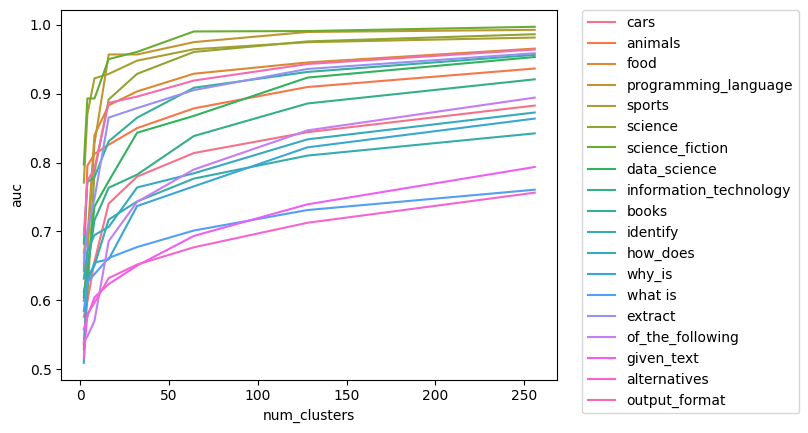

In [40]:
upweighted_animal = [emb + alpha * prj for emb, prj in zip(instruction_data['unit_vector'], projection)]

uwa_dendro = get_cluster_dendrogram(upweighted_animal)

uwa_cluster_assignment_df = get_cluster_assignments(uwa_dendro)

uwa_cluster_rocs_step1 = get_cluster_rocs(pattern_flags, uwa_cluster_assignment_df)  # TO DO: combine these two functions!!!
uwa_cluster_roc_df = extract_cluster_roc_df(uwa_cluster_rocs_step1)

plot_cluster_aucs(uwa_cluster_roc_df)

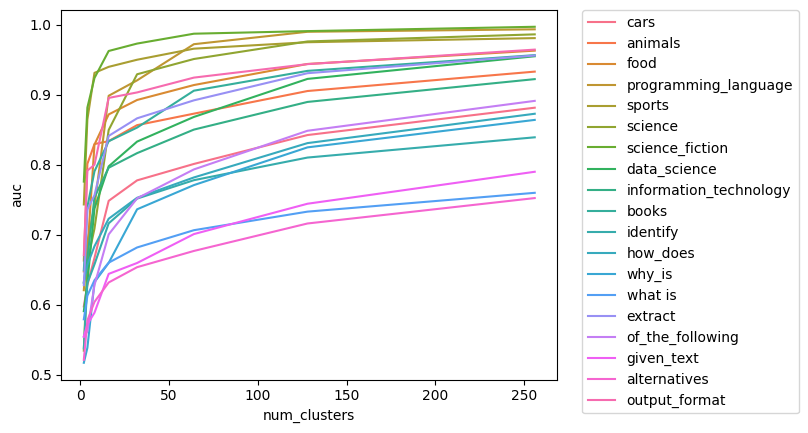

In [41]:
downweighted_animal = [emb - alpha * prj for emb, prj in zip(instruction_data['unit_vector'], projection)]

dwa_dendro = get_cluster_dendrogram(downweighted_animal)

dwa_cluster_assignment_df = get_cluster_assignments(dwa_dendro)

dwa_cluster_rocs_step1 = get_cluster_rocs(pattern_flags, dwa_cluster_assignment_df)  # TO DO: combine these two functions!!!
dwa_cluster_roc_df = extract_cluster_roc_df(dwa_cluster_rocs_step1)

plot_cluster_aucs(dwa_cluster_roc_df)

8 ['0.643', '0.795', '0.813', '0.826', '0.850', '0.879', '0.910', '0.937']


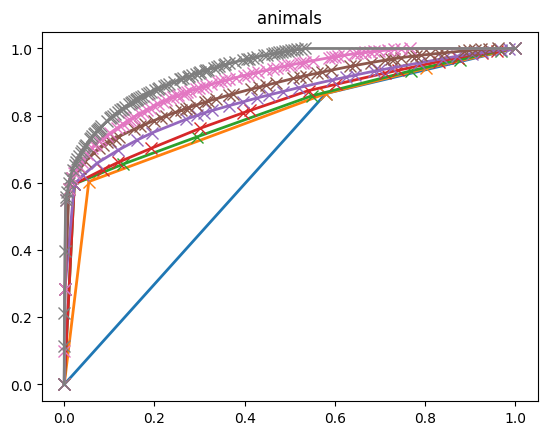

In [42]:
plot_aspect_roc_curves('animals', uwa_cluster_roc_df)

8 ['0.663', '0.801', '0.829', '0.834', '0.857', '0.873', '0.905', '0.933']


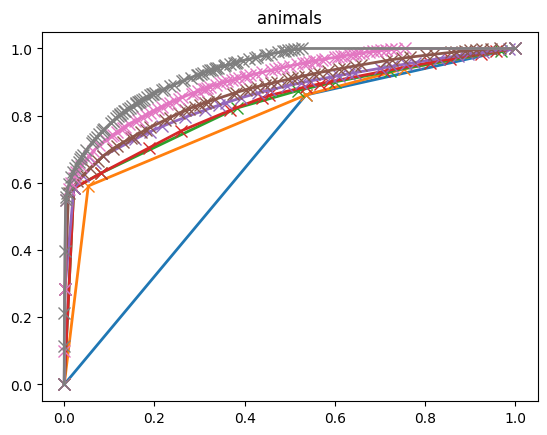

In [43]:
plot_aspect_roc_curves('animals', dwa_cluster_roc_df)

8 ['0.516', '0.580', '0.597', '0.632', '0.652', '0.677', '0.713', '0.756']


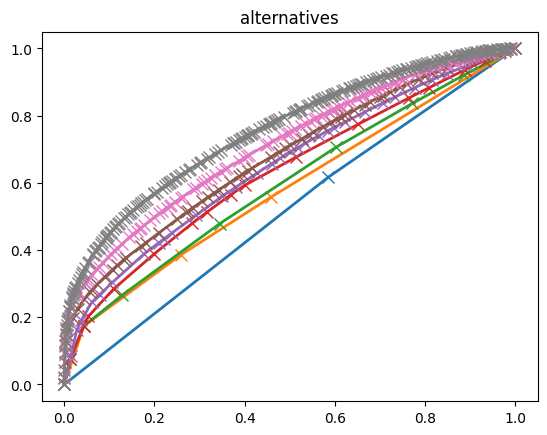

In [44]:
plot_aspect_roc_curves('alternatives', uwa_cluster_roc_df)

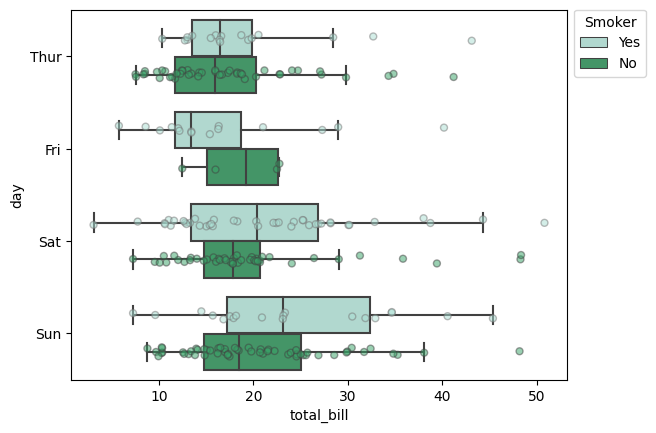

In [86]:
import seaborn as sns

# load the dataframe
tips = sns.load_dataset('tips')

common_params = {'y': "day", 'x': "total_bill", 'hue': "smoker", 'data': tips, 'palette': "BuGn"}
ax = sns.boxplot(fliersize=0, **common_params)

# add stripplot with dodge=True
sns.stripplot(dodge=True, ax=ax, ec='k', linewidth=1, alpha=0.5, **common_params)

# remove extra legend handles and place legend outside bbox
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[:2], labels[:2], title='Smoker', bbox_to_anchor=(1, 1.02), loc='upper left')


AttributeError: 'Axes' object has no attribute 'xlim'

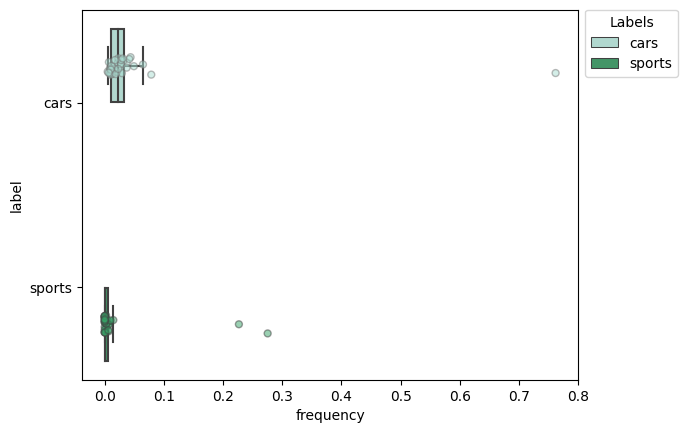

In [90]:
common_params = {'y': "label", 'x': "frequency", 'hue': "label", 'data': cf_long, 'palette': "BuGn"}
ax = sns.boxplot(fliersize=0, **common_params)

# add stripplot with dodge=True
sns.stripplot(dodge=True, ax=ax, ec='k', linewidth=1, alpha=0.5, **common_params)

# remove extra legend handles and place legend outside bbox
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[:2], labels[:2], title='Labels', bbox_to_anchor=(1, 1.02), loc='upper left')
ax.xlim(0,1)


In [88]:
clusterings = cluster_assignment_df[['E', 'F']]
flags_df = pattern_flags[['cars', 'sports']]
cfdf = clusterings.join(flags_df)

ccol = clusterings.columns[0]
cluster_frequencies = cfdf[[ccol, *flags_df.columns]].groupby(ccol).mean().reset_index()

cf_long = pd.melt(cluster_frequencies, id_vars=ccol, var_name='label', value_name='frequency')
cf_long

,E,label,frequency
0,1,cars,0.022459
1,2,cars,0.005076
2,3,cars,0.011161
3,4,cars,0.020595
4,5,cars,0.008798
...,...,...,...
59,28,sports,0.009836
60,29,sports,0.000000
61,30,sports,0.000000
62,31,sports,0.000000


# In Progress

In [ ]:

# Modify `plot_aspect_roc_curves` to use a specified color spectrum. We want to represent multiple sets of ROC curves in the same plot with
# a distinguishable spectrum for each plot.
reds = hue_spectrum(8, hue=0, saturation=1)
print("reds =", reds)

blues = hue_spectrum(8, hue=2/3, saturation=1)
print("blues =", blues)

In [ ]:
# text_col = 'instruction'
# for pattern_name in patterns:
#     flag_vector = [bool(regex.search(patterns[pattern_name], sent, regex.IGNORECASE)) for sent in instruction_data[text_col]]
#     instruction_data[f"{pattern_name}_flag"] = flag_vector
#     print(pattern_name, sum(flag_vector))

# class WeightableClustering():
#     """A single text vector can have multiple embeddings, each of which can be used for multiple clusterings."""
#     def __init__(self, text_list):
#         self.text = text_list
#         self.embeddings = {}    # key = name, value=list of embedding vectors
#         self.ClusterTrees = {}  # key = descriptor, value = ClusterTree object

#     def add_embedding(self, embedding_name, embedding_obj):
#         self.embeddings[embedding_name] = embedding_obj

# class ClusterTree():

#     def __init__(self, text_list):
#         self.embedding = []   # embedding vectors
#         self.dendrograms = {}  # key = descriptor, value = ClusterTree object

# from scipy.cluster.hierarchy import ward, fcluster
# from scipy.spatial.distance import pdist
# import math

# # cluster by the sentence vectors
# vector_list = instruction_data['unit_vector'].tolist()
# D = pdist(vector_list, metric='cosine') # condensed pairwise distance matrix
# dendro = ward(D) # linkage matrix representing a dendrogram [cl1, cl2, distance, size of merged cluster)

# cluster_assignments = [] # list of dicts: {num_cluters, cluster_ids}
# for num_clusters in [10, 20, 40, 80, 160, 320]:
#     cluster_ids = fcluster(dendro, num_clusters, criterion='maxclust')
#     cluster_assignments.append({'num_clusters': num_clusters, 'cluster_ids': cluster_ids})

# zdf = pd.DataFrame(z, columns=['c1', 'c2', 'd', 'n'])
# zdf[zdf['c1'] < 2]